# conseption et realisation d'un dashbord et d'un modele de detection de fraude des données de la Direction des Grandes Entreprise

## Preparation des données

### Importation des modules 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools


### parametrages des modules 

In [2]:
sns.set_theme()
#pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns

### selection, affichage et filtrage des fichiers

In [3]:
TVA = pd.read_excel('VraiTVA.xlsx')
#TVA

In [4]:
ERA = pd.read_excel('VraiERA.xlsx')
#ERA

In [5]:
jointure = pd.merge(ERA, TVA, on='BP', how='inner')
#jointure = jointure[['BP', 'Wilaya', 'Code CNRC', 'Code ONS', 'Chiffre d’affaire (C.A)', 'Total TVA anuelle']]  

In [6]:
jointure.rename(columns={'Chiffre d’affaire (C.A)': 'ChAff'}, inplace=True)
jointure.rename(columns={'Total TVA anuelle': 'Total TVA anunelle'}, inplace=True)
#jointure.head()

### créer la colonne feature et cible


In [7]:
jointure['feature'] =  jointure['ChAff']  - jointure['Total TVA anunelle'] 

In [8]:
def estime(row):
    if row['ChAff'] == 0 or row['Total TVA anunelle'] ==0 :
        return 'sus'
    elif abs(row['feature']) > 1000:
        return 'fraude'
    else:
        return 'bon'

jointure['cible'] = jointure.apply(estime, axis=1)


In [9]:
jointure.head()

,BP,Wilaya,Code CNRC,Code ONS,ChAff,Total TVA Janvier,Total TVA Février,Total TVA Mars,Total TVA Avril,Total TVA Mai,Total TVA Juin,Total TVA Juillet,Total TVA Août,Total TVA Septembre,Total TVA Octobre,Total TVA Novembre,Total TVA Décembre,Total TVA anunelle,feature,cible
0,2000000147,DIW Alger est,607047,/,0,4.381490e+09,4.710011e+09,5.358351e+09,4.811742e+09,4.835182e+09,4.467203e+09,3.692317e+09,3.713033e+09,5.274394e+09,6.056911e+09,4.706919e+09,5.852010e+09,5.785956e+10,-5.785956e+10,sus
1,2000000200,DIW Alger est,608001,/,93115698,6.441810e+05,1.478702e+06,2.304256e+06,1.226741e+06,2.147761e+07,3.343922e+07,9.184847e+06,4.261077e+06,3.033041e+06,4.966790e+06,5.425418e+06,5.673810e+06,9.311570e+07,0.000000e+00,bon
2,2000007178,DIW Bordj Bou Arréridj,110202,/,155423274,4.872747e+06,4.275042e+06,3.918504e+06,6.082352e+06,7.774514e+06,2.706730e+07,2.240796e+07,8.738202e+06,5.113770e+06,5.666626e+06,2.643794e+07,3.306832e+07,1.554233e+08,0.000000e+00,bon
3,2000009570,DIW Alger est,405105,/,5798168362,4.232086e+08,3.965581e+08,4.111293e+08,6.288660e+08,3.132802e+08,4.100639e+08,3.332674e+08,5.615210e+08,7.133190e+08,4.950724e+08,5.964098e+08,5.272515e+08,5.809947e+09,-1.177863e+07,fraude
4,2000011509,DIW Alger est,409001,/,2062602782,1.607687e+08,2.937824e+08,3.321080e+08,1.234689e+08,1.051586e+08,2.330517e+08,1.305186e+08,1.720886e+08,1.598969e+08,1.437596e+08,7.488136e+07,1.328862e+08,2.062370e+09,2.331380e+05,fraude


## Over sample de la donnée fraude dans le data set

In [10]:
# Get the counts of each class
fraud_count = jointure['cible'].value_counts()
print(fraud_count)

# Specify the class you want to oversample, in this case, 'fraude'
target_class = 'fraude'

# Define the number of samples you want for the 'fraude' class after oversampling
# Here, you can use a multiplier to specify how many times larger the 'fraude' class should be
multiplier = 3
target_sample_count = fraud_count[target_class] * multiplier

# Calculate the additional samples you need
additional_samples = target_sample_count - fraud_count[target_class]

# Filter the 'fraude' class
fraude_data = jointure[jointure['cible'] == target_class]

# Randomly sample from the 'fraude' data
oversampled_fraude = fraude_data.sample(n=additional_samples, replace=True, random_state=42)

# Append the oversampled data to the original DataFrame
jointure_oversampled = pd.concat([jointure, oversampled_fraude])

# Shuffle the dataset to mix the rows up
jointure_oversampled = jointure_oversampled.sample(frac=1, random_state=42).reset_index(drop=True)


cible
fraude    720
sus       340
bon       210
Name: count, dtype: int64


### Verification du nouveau data set

In [11]:
print(jointure_oversampled['cible'].value_counts())

cible
fraude    2160
sus        340
bon        210
Name: count, dtype: int64


In [12]:
print(jointure_oversampled.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2710 entries, 0 to 2709
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   BP                   2710 non-null   int64  
 1   Wilaya               2710 non-null   object 
 2   Code CNRC            2710 non-null   object 
 3   Code ONS             2710 non-null   object 
 4   ChAff                2710 non-null   int64  
 5   Total TVA Janvier    2710 non-null   float64
 6   Total TVA Février    2710 non-null   float64
 7   Total TVA Mars       2710 non-null   float64
 8   Total TVA Avril      2710 non-null   float64
 9   Total TVA Mai        2710 non-null   float64
 10  Total TVA Juin       2710 non-null   float64
 11  Total TVA Juillet    2710 non-null   float64
 12  Total TVA Août       2710 non-null   float64
 13  Total TVA Septembre  2710 non-null   float64
 14  Total TVA Octobre    2710 non-null   float64
 15  Total TVA Novembre   2710 non-null   f

## Encodage categoriel & Normalisation/Standardisation 

### encodage categoriel des wilaya

In [13]:
wilaya_count = jointure_oversampled['Wilaya'].value_counts()
print(wilaya_count)

Wilaya
DIW Alger centre          1142
DIW Alger est              419
DIW Alger ouest            192
DIW Oran Est               135
DIW Blida                   97
DIW Ouargla                 96
DIW Constantine             65
DIW Boumerdès               62
DIW Béjaïa                  53
DIW Annaba                  44
DIW Batna                   40
DIW Sétif                   37
DIW Sidi Bel Abbes          29
DIW Skikda                  29
DIW Tipaza                  26
DIW Tlemcen                 23
DIW Bouira                  23
DIW Bordj Bou Arréridj      22
DIW Tizi Ouzou              20
DIW M'Sila                  18
DIW Mostaganem              17
DIW Chlef                   17
DIW Biskra                  11
DIW Mila                     9
DIW Jijel                    9
DIW El Oued                  9
DIW Saïda                    7
DIW Oum el-Bouaghi           7
DIW Khenchela                6
DIW Guelma                   6
Non affecté                  6
DIW Oran Ouest               5
D

In [14]:
# Clean and standardize the Wilaya names
jointure_oversampled['Standardized_Wilaya'] = jointure_oversampled['Wilaya'].str.replace('DIW ', '')

# Label Encoding
wilaya_mapping = {name: i + 1 for i, name in enumerate(jointure_oversampled['Standardized_Wilaya'].unique())}
jointure_oversampled['Wilaya_encoded'] = jointure_oversampled['Standardized_Wilaya'].map(wilaya_mapping)

# Display the DataFrame to check the new columns
print(jointure_oversampled[['Wilaya', 'Standardized_Wilaya', 'Wilaya_encoded']])

                Wilaya Standardized_Wilaya  Wilaya_encoded
0     DIW Alger centre        Alger centre               1
1        DIW Alger est           Alger est               2
2           DIW Skikda              Skikda               3
3     DIW Alger centre        Alger centre               1
4        DIW Alger est           Alger est               2
...                ...                 ...             ...
2705  DIW Alger centre        Alger centre               1
2706  DIW Alger centre        Alger centre               1
2707  DIW Alger centre        Alger centre               1
2708  DIW Alger centre        Alger centre               1
2709   DIW Alger ouest         Alger ouest               5

[2710 rows x 3 columns]


### encodage categoriel des Codes ONS et CNRC

In [15]:
# Label Encoding for 'code CNRC'
cnrc_unique = pd.unique(jointure_oversampled['Code CNRC'])
code_cnrc_mapping = {code: idx + 1 for idx, code in enumerate(cnrc_unique)}
jointure_oversampled['code CNRC_encoded'] = jointure_oversampled['Code CNRC'].map(code_cnrc_mapping)

# Label Encoding for 'code ONS'
ons_unique = pd.unique(jointure_oversampled['Code ONS'])
code_ons_mapping = {code: idx + 1 for idx, code in enumerate(ons_unique)}
jointure_oversampled['code ONS_encoded'] = jointure_oversampled['Code ONS'].map(code_ons_mapping)

# Display the DataFrame to check the new columns
print(jointure_oversampled)

              BP            Wilaya Code CNRC Code ONS       ChAff  \
0     2000046165  DIW Alger centre         /        /    99363071   
1     2000045681     DIW Alger est    107602        /  3970644114   
2     2000045280        DIW Skikda    442101        /  2440169831   
3     2000044967  DIW Alger centre    612103        /  5233521522   
4     2000044599     DIW Alger est         /        /  1194321408   
...          ...               ...       ...      ...         ...   
2705  2000044848  DIW Alger centre    303101        /     6061064   
2706  2000046555  DIW Alger centre    613203     4329           0   
2707  2000046633  DIW Alger centre    613125     4321    22988920   
2708  2000044945  DIW Alger centre         /        /  1802091898   
2709  2000045829   DIW Alger ouest         /        /   113184009   

      Total TVA Janvier  Total TVA Février  Total TVA Mars  Total TVA Avril  \
0                   0.0          9274376.0      11693299.0         818104.0   
1           2

### encodage categoriel de target ENFIN

In [16]:
target_mapping = {
    'bon': 0,      # Typically, the "normal" class can be zero
    'fraude': 1,   # Positive class can be one, especially if it's a binary classification
    'sus': 2       # Additional class can take the next integer
}

# Apply the mapping to the target column
jointure_oversampled['target_encoded'] = jointure_oversampled['cible'].map(target_mapping)

# Display the DataFrame to check the new column
print(jointure_oversampled[['cible', 'target_encoded']])

       cible  target_encoded
0     fraude               1
1     fraude               1
2        bon               0
3     fraude               1
4     fraude               1
...      ...             ...
2705  fraude               1
2706     sus               2
2707  fraude               1
2708  fraude               1
2709     sus               2

[2710 rows x 2 columns]


### verification du Data set :SOB: + supression des columns not needed 

In [17]:
jointure_oversampled

,BP,Wilaya,Code CNRC,Code ONS,ChAff,Total TVA Janvier,Total TVA Février,Total TVA Mars,Total TVA Avril,Total TVA Mai,Total TVA Juin,Total TVA Juillet,Total TVA Août,Total TVA Septembre,Total TVA Octobre,Total TVA Novembre,Total TVA Décembre,Total TVA anunelle,feature,cible,Standardized_Wilaya,Wilaya_encoded,code CNRC_encoded,code ONS_encoded,target_encoded
0,2000046165,DIW Alger centre,/,/,99363071,0.0,9274376.0,11693299.0,818104.0,0.0,0.0,0.0,0.0,20057995.0,22456296.0,0.0,0.0,6.430007e+07,35063001.0,fraude,Alger centre,1,1,1,1
1,2000045681,DIW Alger est,107602,/,3970644114,264306135.0,308655156.0,309484102.0,244229322.0,364340910.0,301658269.0,311550300.0,354170527.0,377256263.0,371834649.0,382373285.0,379694536.0,3.969553e+09,1090660.0,fraude,Alger est,2,2,1,1
2,2000045280,DIW Skikda,442101,/,2440169831,53934535.0,31330863.0,54038932.0,74313284.0,123784873.0,126395176.0,164957735.0,251992512.0,255887330.0,417669337.0,345197258.0,540667994.0,2.440170e+09,2.0,bon,Skikda,3,3,1,0
3,2000044967,DIW Alger centre,612103,/,5233521522,267827399.0,245092716.0,661937406.0,247560393.0,195718110.0,613428544.0,266874441.0,370386787.0,428682064.0,667021863.0,437860632.0,607494245.0,5.009885e+09,223636922.0,fraude,Alger centre,1,4,1,1
4,2000044599,DIW Alger est,/,/,1194321408,129495040.0,116658476.0,113137331.0,134458418.0,80168209.0,90902273.0,140560128.0,63062661.0,60781780.0,137059642.0,73424922.0,255048174.0,1.394757e+09,-200435646.0,fraude,Alger est,2,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2705,2000044848,DIW Alger centre,303101,/,6061064,675771.0,1301486.0,1164440.0,618145.0,399810.0,0.0,351235.0,421755.0,758092.0,0.0,394202.0,14985980.0,2.107092e+07,-15009852.0,fraude,Alger centre,1,155,1,1
2706,2000046555,DIW Alger centre,613203,4329,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,sus,Alger centre,1,15,5,2
2707,2000046633,DIW Alger centre,613125,4321,22988920,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2954700.0,2.954700e+06,20034220.0,fraude,Alger centre,1,25,7,1
2708,2000044945,DIW Alger centre,/,/,1802091898,108453762.0,106550220.0,150698252.0,42561555.0,165152128.0,190382304.0,151130637.0,169358678.0,168960276.0,221934866.0,178735475.0,166549636.0,1.820468e+09,-18375891.0,fraude,Alger centre,1,1,1,1


In [18]:
print(jointure_oversampled.columns)

Index(['BP', 'Wilaya', 'Code CNRC', 'Code ONS', 'ChAff', 'Total TVA Janvier',
       'Total TVA Février', 'Total TVA Mars', 'Total TVA Avril',
       'Total TVA Mai', 'Total TVA Juin', 'Total TVA Juillet',
       'Total TVA Août', 'Total TVA Septembre', 'Total TVA Octobre',
       'Total TVA Novembre', 'Total TVA Décembre', 'Total TVA anunelle',
       'feature', 'cible', 'Standardized_Wilaya', 'Wilaya_encoded',
       'code CNRC_encoded', 'code ONS_encoded', 'target_encoded'],
      dtype='object')


In [19]:
jointure_oversampled = jointure_oversampled.drop(columns = ['Wilaya', 'Code CNRC', 'Code ONS','cible'])

In [20]:
jointure_oversampled = jointure_oversampled.drop(columns = ['Standardized_Wilaya'])

In [21]:
jointure_oversampled

,BP,ChAff,Total TVA Janvier,Total TVA Février,Total TVA Mars,Total TVA Avril,Total TVA Mai,Total TVA Juin,Total TVA Juillet,Total TVA Août,Total TVA Septembre,Total TVA Octobre,Total TVA Novembre,Total TVA Décembre,Total TVA anunelle,feature,Wilaya_encoded,code CNRC_encoded,code ONS_encoded,target_encoded
0,2000046165,99363071,0.0,9274376.0,11693299.0,818104.0,0.0,0.0,0.0,0.0,20057995.0,22456296.0,0.0,0.0,6.430007e+07,35063001.0,1,1,1,1
1,2000045681,3970644114,264306135.0,308655156.0,309484102.0,244229322.0,364340910.0,301658269.0,311550300.0,354170527.0,377256263.0,371834649.0,382373285.0,379694536.0,3.969553e+09,1090660.0,2,2,1,1
2,2000045280,2440169831,53934535.0,31330863.0,54038932.0,74313284.0,123784873.0,126395176.0,164957735.0,251992512.0,255887330.0,417669337.0,345197258.0,540667994.0,2.440170e+09,2.0,3,3,1,0
3,2000044967,5233521522,267827399.0,245092716.0,661937406.0,247560393.0,195718110.0,613428544.0,266874441.0,370386787.0,428682064.0,667021863.0,437860632.0,607494245.0,5.009885e+09,223636922.0,1,4,1,1
4,2000044599,1194321408,129495040.0,116658476.0,113137331.0,134458418.0,80168209.0,90902273.0,140560128.0,63062661.0,60781780.0,137059642.0,73424922.0,255048174.0,1.394757e+09,-200435646.0,2,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2705,2000044848,6061064,675771.0,1301486.0,1164440.0,618145.0,399810.0,0.0,351235.0,421755.0,758092.0,0.0,394202.0,14985980.0,2.107092e+07,-15009852.0,1,155,1,1
2706,2000046555,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,1,15,5,2
2707,2000046633,22988920,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2954700.0,2.954700e+06,20034220.0,1,25,7,1
2708,2000044945,1802091898,108453762.0,106550220.0,150698252.0,42561555.0,165152128.0,190382304.0,151130637.0,169358678.0,168960276.0,221934866.0,178735475.0,166549636.0,1.820468e+09,-18375891.0,1,1,1,1


### normalisation et standardisation 
 vu que nous allons faire a random forest and/or a regression tree, il serait preferable de standardiser les données 

In [22]:
jointure_oversampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2710 entries, 0 to 2709
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   BP                   2710 non-null   int64  
 1   ChAff                2710 non-null   int64  
 2   Total TVA Janvier    2710 non-null   float64
 3   Total TVA Février    2710 non-null   float64
 4   Total TVA Mars       2710 non-null   float64
 5   Total TVA Avril      2710 non-null   float64
 6   Total TVA Mai        2710 non-null   float64
 7   Total TVA Juin       2710 non-null   float64
 8   Total TVA Juillet    2710 non-null   float64
 9   Total TVA Août       2710 non-null   float64
 10  Total TVA Septembre  2710 non-null   float64
 11  Total TVA Octobre    2710 non-null   float64
 12  Total TVA Novembre   2710 non-null   float64
 13  Total TVA Décembre   2710 non-null   float64
 14  Total TVA anunelle   2710 non-null   float64
 15  feature              2710 non-null   f

In [23]:
columns_to_standardize = [
    'ChAff',
    'Total TVA Janvier', 'Total TVA Février', 'Total TVA Mars', 'Total TVA Avril',
    'Total TVA Mai', 'Total TVA Juin', 'Total TVA Juillet', 'Total TVA Août',
    'Total TVA Septembre', 'Total TVA Octobre', 'Total TVA Novembre', 'Total TVA Décembre',
    'Total TVA anunelle'
]

# Apply standardization
for column in columns_to_standardize:
    jointure_oversampled[column] = (jointure_oversampled[column] - jointure_oversampled[column].mean()) / jointure_oversampled[column].std()

# Now your columns are standardized
print(jointure_oversampled[columns_to_standardize].head())

      ChAff  Total TVA Janvier  Total TVA Février  Total TVA Mars  \
0 -0.079947          -0.212079          -0.226953       -0.236876   
1 -0.058348          -0.133323          -0.121197       -0.143873   
2 -0.066887          -0.196008          -0.219162       -0.223651   
3 -0.051302          -0.132273          -0.143650       -0.033799   
4 -0.073838          -0.173493          -0.189020       -0.205194   

   Total TVA Avril  Total TVA Mai  Total TVA Juin  Total TVA Juillet  \
0        -0.219269      -0.220954       -0.223809          -0.210407   
1        -0.146250      -0.112030       -0.131984          -0.111179   
2        -0.197222      -0.183947       -0.185334          -0.157868   
3        -0.145251      -0.162442       -0.037082          -0.125408   
4        -0.179179      -0.196987       -0.196138          -0.165639   

   Total TVA Août  Total TVA Septembre  Total TVA Octobre  Total TVA Novembre  \
0       -0.220704            -0.226184          -0.226540           -0.

## Modele KNN

In [24]:
jointure_oversampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2710 entries, 0 to 2709
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   BP                   2710 non-null   int64  
 1   ChAff                2710 non-null   float64
 2   Total TVA Janvier    2710 non-null   float64
 3   Total TVA Février    2710 non-null   float64
 4   Total TVA Mars       2710 non-null   float64
 5   Total TVA Avril      2710 non-null   float64
 6   Total TVA Mai        2710 non-null   float64
 7   Total TVA Juin       2710 non-null   float64
 8   Total TVA Juillet    2710 non-null   float64
 9   Total TVA Août       2710 non-null   float64
 10  Total TVA Septembre  2710 non-null   float64
 11  Total TVA Octobre    2710 non-null   float64
 12  Total TVA Novembre   2710 non-null   float64
 13  Total TVA Décembre   2710 non-null   float64
 14  Total TVA anunelle   2710 non-null   float64
 15  feature              2710 non-null   f

In [25]:
import numpy as np

class KNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        # Compute distances between x and all examples in the training set
        distances = [np.sqrt(np.sum((x_train - x) ** 2)) for x_train in self.X_train]
        # Sort by distance and return indices of the first k neighbors
        k_indices = np.argsort(distances)[:self.k]
        # Extract the labels of the k nearest neighbor training samples
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        # Return the most common class label
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

# Usage
from collections import Counter
from sklearn.model_selection import train_test_split

# Assuming 'jointure_oversampled' is your DataFrame and you want to predict 'target_encoded' using k-NN

# Convert DataFrame to numpy array for easier manipulation
X = jointure_oversampled.drop(columns=['target_encoded']).values
y = jointure_oversampled['target_encoded'].values

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating and training the k-NN classifier
knn = KNN(k=3)
knn.fit(X_train, y_train)

# Making predictions on the test set
predictions = knn.predict(X_test)

# Evaluating the model
accuracy = np.sum(predictions == y_test) / len(y_test)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.90


In [26]:
from collections import Counter

def precision_recall_f1(y_true, y_pred):
    # Calculate precision and recall for each class
    classes = np.unique(y_true)
    precision = {}
    recall = {}
    f1 = {}
    support = Counter(y_true)
    
    for cls in classes:
        tp = np.sum((y_pred == cls) & (y_true == cls))
        tp_fp = np.sum(y_pred == cls)
        tp_fn = np.sum(y_true == cls)
        
        precision[cls] = tp / tp_fp if tp_fp > 0 else 0
        recall[cls] = tp / tp_fn if tp_fn > 0 else 0
        f1[cls] = 2 * (precision[cls] * recall[cls]) / (precision[cls] + recall[cls]) if (precision[cls] + recall[cls]) > 0 else 0
    
    return precision, recall, f1, support

def accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

# Example usage:
precision, recall, f1, support = precision_recall_f1(y_test, predictions)
acc = accuracy(y_test, predictions)

print("Class\tPrecision\tRecall\tF1-Score\tSupport")
for cls in np.unique(y_test):
    print(f"{cls}\t{precision[cls]:.2f}\t\t{recall[cls]:.2f}\t{f1[cls]:.2f}\t\t{support[cls]}")

print(f"\nAccuracy: {acc:.2f}")


Class	Precision	Recall	F1-Score	Support
0	0.71		0.74	0.72		46
1	0.94		1.00	0.97		419
2	0.74		0.48	0.58		77

Accuracy: 0.90


In [27]:
def compute_confusion_matrix(y_true, y_pred):
    classes = np.unique(y_true)
    matrix = np.zeros((len(classes), len(classes)), dtype=int)
    for i in range(len(classes)):
        for j in range(len(classes)):
            matrix[i, j] = np.sum((y_true == classes[i]) & (y_pred == classes[j]))
    return matrix


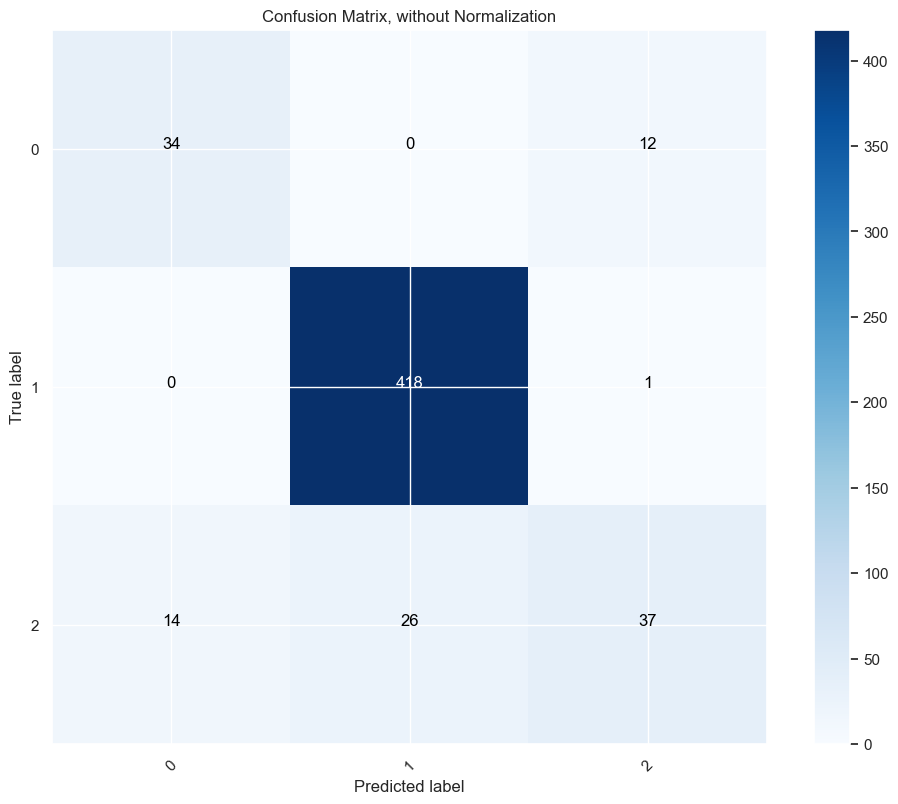

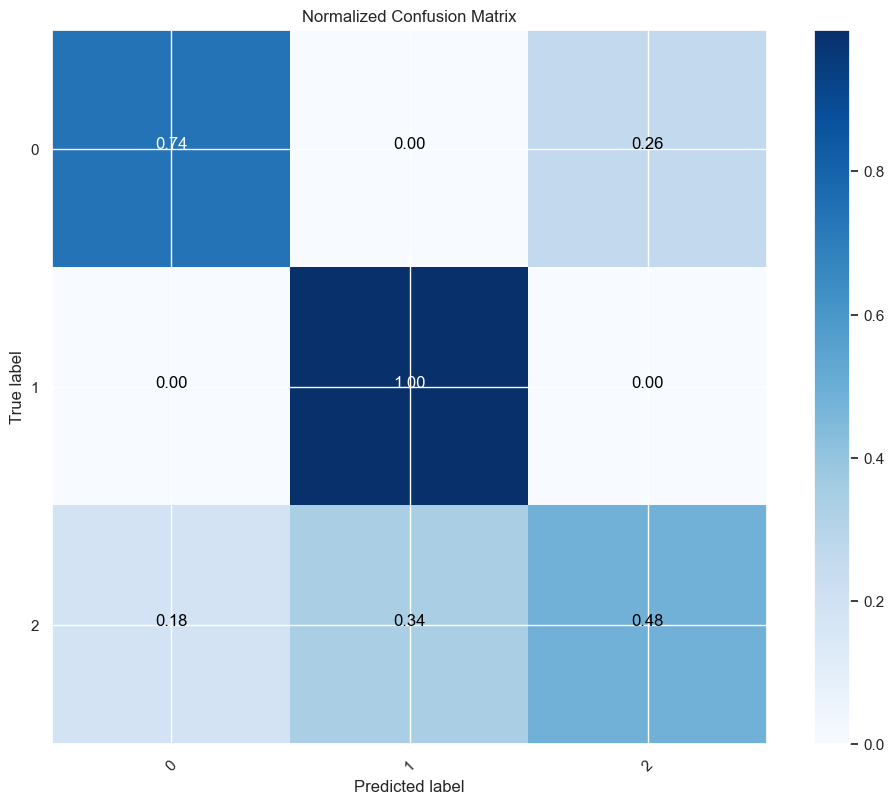

In [28]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Calculate the confusion matrix
conf_matrix = compute_confusion_matrix(y_test, predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plot_confusion_matrix(conf_matrix, classes=np.unique(y_test),
                      title='Confusion Matrix, without Normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10, 8))
plot_confusion_matrix(conf_matrix, classes=np.unique(y_test), normalize=True,
                      title='Normalized Confusion Matrix')

plt.show()


In [29]:
#1000